In [1]:
# STEP 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tarfile
import os
import pickle
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

2025-07-09 06:11:01.748983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 06:11:01.749035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 06:11:01.851761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 06:11:02.045312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-09 06:11:03.402256: W tensorflow/compiler/tf2

In [2]:
# STEP 2: Load CIFAR-10 Data
file_path = '/home/nikola/Documents/Assignment-9/cifar-10-python.tar.gz'
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path='./cifar10_data')

def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        data = batch['data']
        labels = batch['labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(labels)

x_train, y_train = [], []
for i in range(1, 6):
    data_batch, labels_batch = load_cifar_batch(f'./cifar10_data/cifar-10-batches-py/data_batch_{i}')
    x_train.append(data_batch)
    y_train.append(labels_batch)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

x_test, y_test = load_cifar_batch('./cifar10_data/cifar-10-batches-py/test_batch')
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [3]:
# STEP 3: Add Gaussian Noise
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
# STEP 4: Build Denoising Autoencoder
def build_denoising_autoencoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    
    x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    
    return models.Model(inputs, decoded)

autoencoder = build_denoising_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

2025-07-09 06:11:23.639595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 06:11:24.176664: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# STEP 5: Train the Denoising Autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
391/391 [==============================] - 59s 149ms/step - loss: 0.0143 - val_loss: 0.0084
Epoch 2/20
391/391 [==============================] - 61s 156ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 3/20
391/391 [==============================] - 59s 150ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 4/20
391/391 [==============================] - 68s 173ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 5/20
391/391 [==============================] - 74s 188ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/20
391/391 [==============================] - 64s 164ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 7/20
391/391 [==============================] - 65s 166ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 8/20
391/391 [==============================] - 57s 146ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/20
391/391 [==============================] - 55s 141ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/20
391/391 [==============================] - 55s 141ms/step - l

1/1 [==============================] - 0s 81ms/step


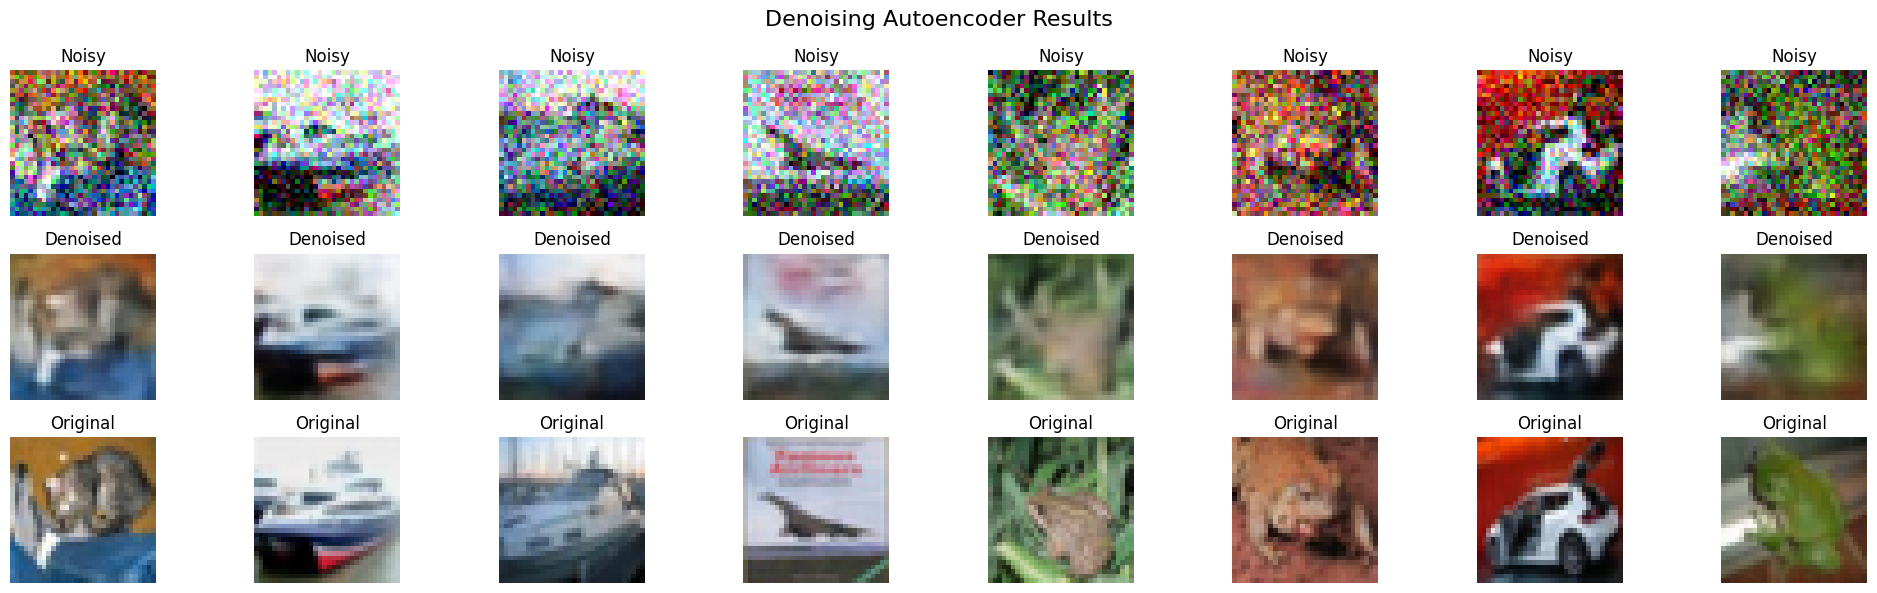

In [6]:
# STEP 6: Visualize Denoising Results
n = 8
decoded_imgs = autoencoder.predict(x_test_noisy[:n])

plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis('off')
    
    # Denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis('off')
    
    # Ground truth
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')

plt.suptitle("Denoising Autoencoder Results", fontsize=16)
plt.tight_layout()
plt.show()